In [ ]:
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

```{autolink-concat}
```

# [TR-011] Symbolic kinematics

:::{note}

This report has been implemented in and {pr}`ComPWA/ampform#177` and  {pr}`ComPWA/tensorwaves#345`. The report contains some bugs which were also addressed in these PRs.

:::

:::{warning}

This notebook requires {pr}`sympy/sympy#22265`, which has not released at the time of writing.

:::

```{autolink-skip}
```

In [ ]:
%pip install -q ampform==0.11.4 black==21.7b0 graphviz==0.17 numpy==1.22.2 qrules==0.9.2 git+https://github.com/ComPWA/sympy@20570-add-ArraySlice

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import inspect
from typing import Any, Dict, Optional

import black
import graphviz
import numpy as np
import qrules
import sympy as sp
from ampform.data import EventCollection
from ampform.kinematics import (
    _compute_helicity_angles,
    determine_attached_final_state,
    get_helicity_angle_label,
)
from ampform.sympy import (
    UnevaluatedExpression,
    create_expression,
    implement_doit_method,
)
from IPython.display import Math
from qrules.topology import Topology, create_isobar_topologies
from sympy.printing.numpy import NumPyPrinter
from sympy.printing.printer import Printer
from sympy.tensor.array.expressions.array_expressions import (
    ArraySlice,
    ArraySymbol,
)

This report investigates issue {issue}`56`. The ideal solution would be to use only SymPy in the existing [`ampform.kinematics`](https://ampform.readthedocs.io/en/0.11.4/api/ampform.kinematics.html) module. This has two benefits:

1. It allows computing kinematic variables from four-momenta with different computational back-ends.
2. Expressions for kinematic variable can be inspected through their LaTeX representation.

To simplify things, we investigate 1. by only lambdifying to NumPy. It should be relatively straightforward to lambdify to other back-ends like TensorFlow (as long as they support Einstein summation).

## Test sample

Data sample taken from [this test in AmpForm](https://github.com/ComPWA/ampform/tree/0.11.4/tests/conftest.py#L53-L115) and topology and expected angles taken from [here](https://github.com/ComPWA/ampform/tree/0.11.4/tests/test_kinematics.py#L15-L112).

In [ ]:
topologies = create_isobar_topologies(4)
topology = topologies[1]

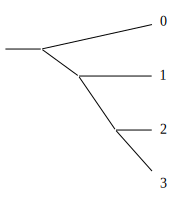

In [ ]:
dot = qrules.io.asdot(topology)
graphviz.Source(dot)

In [ ]:
events = EventCollection(
    {
        0: np.array(  # pi0
            [
                (1.35527, 0.514208, -0.184219, 1.23296),
                (0.841933, 0.0727385, -0.0528868, 0.826163),
                (0.550927, -0.162529, 0.29976, -0.411133),
            ]
        ),
        1: np.array(  # gamma
            [
                (0.755744, -0.305812, 0.284, -0.630057),
                (1.02861, 0.784483, 0.614347, -0.255334),
                (0.356875, -0.20767, 0.272796, 0.0990739),
            ]
        ),
        2: np.array(  # pi0
            [
                (0.208274, -0.061663, -0.0211864, 0.144596),
                (0.461193, -0.243319, -0.283044, -0.234866),
                (1.03294, 0.82872, -0.0465425, -0.599834),
            ]
        ),
        3: np.array(  # pi0
            [
                (0.777613, -0.146733, -0.0785946, -0.747499),
                (0.765168, -0.613903, -0.278416, -0.335962),
                (1.15616, -0.458522, -0.526014, 0.911894),
            ]
        ),
    }
)

In [ ]:
angles = _compute_helicity_angles(events, topology)
angles._DataSet__data

{'phi_1+2+3': ScalarSequence([ 2.79758029  2.51292308 -1.07396684],
 'theta_1+2+3': ScalarSequence([2.72456853 3.03316287 0.69240082],
 'phi_2+3,1+2+3': ScalarSequence([1.0436215  1.8734936  0.16073833],
 'theta_2+3,1+2+3': ScalarSequence([2.45361589 1.40639741 0.98079245],
 'phi_2,2+3,1+2+3': ScalarSequence([ 0.36955786 -1.68820498  0.63063002],
 'theta_2,2+3,1+2+3': ScalarSequence([1.0924374  1.99375767 1.31959621]}

## Einstein summation

First challenge is to express the Einstein summation in [the existing implementation](https://github.com/ComPWA/ampform/tree/0.11.4/src/ampform/data.py#L207-L214) in terms of SymPy. The aim is to render the expression resulting nicely as LaTeX while at the same time being able to lambdify the expression to efficient NumPy code. We do this by deriving from [`UnevaluatedExpression`](https://ampform.readthedocs.io/en/0.11.4/api/ampform.sympy.html#ampform.sympy.UnevaluatedExpression) and using the decorator functions provided by the [`ampform.sympy`](https://ampform.readthedocs.io/en/0.11.4/api/ampform.sympy.html) module.

### Define boost and rotation classes

First, wrap rotations and boosts in a class so with a nice LaTeX printer. {ref}`Later on <report/011:Define lambdification>`, a NumPy printer method will be defined externally for each of them.

In [ ]:
class BoostZ(UnevaluatedExpression):
    def __new__(cls, beta: sp.Symbol, **hints: Any) -> "BoostZ":
        return create_expression(cls, beta, **hints)

    def as_explicit(self) -> sp.Expr:
        gamma = 1 / sp.sqrt(1 - beta**2)
        return sp.Matrix(
            [
                [gamma, 0, 0, -gamma * beta],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [-gamma * beta, 0, 0, gamma],
            ]
        )

    def _latex(self, printer, *args) -> str:
        beta, *_ = self.args
        beta = printer._print(beta)
        return Rf"\boldsymbol{{B_z}}\left({beta}\right)"

In [ ]:
class RotationY(UnevaluatedExpression):
    def __new__(cls, angle: sp.Symbol, **hints: Any) -> "RotationY":
        return create_expression(cls, angle, **hints)

    def as_explicit(self) -> sp.Expr:
        angle = self.args[0]
        return sp.Matrix(
            [
                [1, 0, 0, 0],
                [0, sp.cos(angle), 0, sp.sin(angle)],
                [0, 0, 1, 0],
                [0, -sp.sin(angle), 0, sp.cos(angle)],
            ]
        )

    def _latex(self, printer, *args) -> str:
        angle, *_ = self.args
        angle = printer._print(angle)
        return Rf"\boldsymbol{{R_y}}\left({angle}\right)"

In [ ]:
class RotationZ(UnevaluatedExpression):
    def __new__(cls, angle: sp.Symbol, **hints: Any) -> "RotationZ":
        return create_expression(cls, angle, **hints)

    def as_explicit(self) -> sp.Expr:
        angle = self.args[0]
        return sp.Matrix(
            [
                [1, 0, 0, 0],
                [0, sp.cos(angle), -sp.sin(angle), 0],
                [0, sp.sin(angle), sp.cos(angle), 0],
                [0, 0, 0, 1],
            ]
        )

    def _latex(self, printer, *args) -> str:
        angle, *_ = self.args
        angle = printer._print(angle)
        return Rf"\boldsymbol{{R_z}}\left({angle}\right)"

### Define Einstein summation class

Similarly, we define a `ArrayMultiplication` class that will eventually be lambdified to {func}`numpy.einsum`.

(011-array-multiplication)=

In [ ]:
class ArrayMultiplication(sp.Expr):
    def __new__(cls, *tensors: sp.Symbol, **hints: Any):
        return create_expression(cls, *tensors, **hints)

    def _latex(self, printer, *args) -> str:
        tensors_latex = map(printer._print, self.args)
        return " ".join(tensors_latex)

Indeed an expression involving these classes looks nice on the top-level:

In [ ]:
n_events = 3
# n_events = sp.Symbol("n", integer=True, positive=True)
momentum = sp.MatrixSymbol("p", m=n_events, n=4)
beta = sp.Symbol("beta")
phi = sp.Symbol("phi")
theta = sp.Symbol("theta")

boosted_momentum = ArrayMultiplication(
    BoostZ(beta),
    RotationY(-theta),
    RotationZ(-phi),
    momentum,
)
boosted_momentum

ArrayMultiplication(BoostZ(beta), RotationY(-theta), RotationZ(-phi), p)

:::{note}

It could be that the above can be achieved with SymPy's `ArrayTensorProduct` and `ArrayContraction`. See for instance {issue}`sympy/sympy#22279`.

:::

### Define lambdification

In [ ]:
# small helper function
def print_lambdify(symbols, expr):
    np_expr = sp.lambdify(symbols, expr)
    src = inspect.getsource(np_expr)
    src = black.format_str(src, mode=black.Mode(line_length=79))
    print(src)

Now we have a problem: lambdification does not work...

In [ ]:
print_lambdify([beta, theta, momentum], boosted_momentum)

def _lambdifygenerated(beta, theta, p):
    return (  # Not supported in Python with SciPy and NumPy:
        # ArrayMultiplication
        ArrayMultiplication(
            BoostZ(beta), RotationY(-theta), RotationZ(-phi), p
        )
    )



But lambdification can be defined externally to both the SymPy library and the expression classes. Here's an implementation for NumPy where we define the lambdification **through the expression class** (with a `_numpycode` method):

In [ ]:
def print_as_numpy(self, printer: Printer, *args: Any) -> str:
    def multiply(matrix, vector):
        return (
            'einsum("ij...,j...",'
            f" transpose({matrix}, axes=(1, 2, 0)),"
            f" transpose({vector}))"
        )

    def recursive_multiply(tensors):
        if len(tensors) < 2:
            raise ValueError("Need at least two tensors")
        if len(tensors) == 2:
            return multiply(tensors[0], tensors[1])
        return multiply(tensors[0], recursive_multiply(tensors[1:]))

    printer.module_imports["numpy"].update({"einsum", "transpose"})
    tensors = list(map(printer._print, self.args))
    if len(tensors) == 0:
        return ""
    if len(tensors) == 1:
        return tensors[0]
    return recursive_multiply(tensors)


ArrayMultiplication._numpycode = print_as_numpy

In [ ]:
print_lambdify(
    symbols=[beta, theta, momentum],
    expr=ArrayMultiplication(beta, theta, momentum),
)

def _lambdifygenerated(beta, theta, p):
    return einsum(
        "ij...,j...",
        transpose(beta, axes=(1, 2, 0)),
        transpose(
            einsum(
                "ij...,j...", transpose(theta, axes=(1, 2, 0)), transpose(p)
            )
        ),
    )



This also needs to be done for the rotation and boost classes:

In [ ]:
print_lambdify([beta, theta, momentum], boosted_momentum)

def _lambdifygenerated(beta, theta, p):
    return (  # Not supported in Python with SciPy and NumPy:
        # BoostZ
        # RotationY
        # RotationZ
        einsum(
            "ij...,j...",
            transpose(BoostZ(beta), axes=(1, 2, 0)),
            transpose(
                einsum(
                    "ij...,j...",
                    transpose(RotationY(-theta), axes=(1, 2, 0)),
                    transpose(
                        einsum(
                            "ij...,j...",
                            transpose(RotationZ(-phi), axes=(1, 2, 0)),
                            transpose(p),
                        )
                    ),
                )
            ),
        )
    )



This time, we define the lambdification **through the printer class**:

In [ ]:
def _print_BoostZ(self: NumPyPrinter, expr: BoostZ) -> str:
    self.module_imports["numpy"].update({"array", "ones", "zeros", "sqrt"})
    arg = expr.args[0]
    beta = self._print(arg)
    gamma = f"1 / sqrt(1 - ({beta}) ** 2)"
    n_events = f"len({beta})"
    zeros = f"zeros({n_events})"
    ones = f"ones({n_events})"
    return f"""array(
        [
            [{gamma}, {zeros}, {zeros}, -{gamma} * {beta}],
            [{zeros}, {ones}, {zeros}, {zeros}],
            [{zeros}, {zeros}, {ones}, {zeros}],
            [-{gamma} * {beta}, {zeros}, {zeros}, {gamma}],
        ]
    ).transpose(2, 0, 1)"""


NumPyPrinter._print_BoostZ = _print_BoostZ

In [ ]:
def _print_RotationY(self: NumPyPrinter, expr: RotationY) -> str:
    self.module_imports["numpy"].update(
        {"array", "cos", "ones", "zeros", "sin"}
    )
    arg = expr.args[0]
    angle = self._print(arg)
    n_events = f"len({angle})"
    zeros = f"zeros({n_events})"
    ones = f"ones({n_events})"
    return f"""array(
        [
            [{ones}, {zeros}, {zeros}, {zeros}],
            [{zeros}, cos({angle}), {zeros}, sin({angle})],
            [{zeros}, {zeros}, {ones}, {zeros}],
            [{zeros}, -sin({angle}), {zeros}, cos({angle})],
        ]
    ).transpose(2, 0, 1)"""


NumPyPrinter._print_RotationY = _print_RotationY

In [ ]:
def _print_RotationZ(self: NumPyPrinter, expr: RotationZ) -> str:
    self.module_imports["numpy"].update(
        {"array", "cos", "ones", "zeros", "sin"}
    )
    arg = expr.args[0]
    angle = self._print(arg)
    n_events = f"len({angle})"
    zeros = f"zeros({n_events})"
    ones = f"ones({n_events})"
    return f"""array(
        [
            [{ones}, {zeros}, {zeros}, {zeros}],
            [{zeros}, cos({angle}), -sin({angle}), {zeros}],
            [{zeros}, sin({angle}), cos({angle}), {zeros}],
            [{zeros}, {zeros}, {zeros}, {ones}],
        ]
    ).transpose(2, 0, 1)"""


NumPyPrinter._print_RotationZ = _print_RotationZ

In [ ]:
print_lambdify([beta, theta, momentum], boosted_momentum)

def _lambdifygenerated(beta, theta, p):
    return einsum(
        "ij...,j...",
        transpose(
            array(
                [
                    [
                        1 / sqrt(1 - (beta) ** 2),
                        zeros(len(beta)),
                        zeros(len(beta)),
                        -1 / sqrt(1 - (beta) ** 2) * beta,
                    ],
                    [
                        zeros(len(beta)),
                        ones(len(beta)),
                        zeros(len(beta)),
                        zeros(len(beta)),
                    ],
                    [
                        zeros(len(beta)),
                        zeros(len(beta)),
                        ones(len(beta)),
                        zeros(len(beta)),
                    ],
                    [
                        -1 / sqrt(1 - (beta) ** 2) * beta,
                        zeros(len(beta)),
                        zeros(len(beta)),
                        1 / sqrt(1 

:::{note}

The code above contains a lot of duplicate code, such as `len(-phi)`. This could possibly be improved with {class}`~sympy.codegen.ast.CodeBlock`. See {issue}`ComPWA/ampform#166`.

:::

## Angle computation

### Computing phi

The simplest angle to compute is $\phi$, because it's simply $\phi=\arctan(p_y, p_x)$, with $p$ a four-momentum (see [existing implementation](https://github.com/ComPWA/ampform/blob/f38179483ac20664584014d9eb659866966681c2/src/ampform/data.py#L161-L162)). This means we would need a way to represent $p_x$ and $p_y$ and some container for $\phi$ itself. For convenience, we define $p_z$ and $E_p$ as well.

In [ ]:
@implement_doit_method()
class FourMomentumX(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "FourMomentumX":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> ArraySlice:
        return ArraySlice(self.momentum, (slice(None), 1))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return f"{{{momentum}}}_{{x}}"


@implement_doit_method()
class FourMomentumY(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "FourMomentumY":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> ArraySlice:
        return ArraySlice(self.momentum, (slice(None), 2))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return f"{{{momentum}}}_{{y}}"


@implement_doit_method()
class FourMomentumZ(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "FourMomentumZ":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> ArraySlice:
        return ArraySlice(self.momentum, (slice(None), 3))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return f"{{{momentum}}}_{{y}}"


@implement_doit_method()
class Energy(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "Energy":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> ArraySlice:
        return ArraySlice(self.momentum, (slice(None), 0))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return f"{{E}}_{{{momentum}}}"


@implement_doit_method()
class Phi(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "Phi":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> sp.Expr:
        p = self.momentum
        return sp.atan2(FourMomentumY(p), FourMomentumX(p))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return Rf"\phi\left({momentum}\right)"

The classes indeed render nicely as LaTeX:

In [ ]:
p = ArraySymbol("p_1")
phi = Phi(p)
p_x = FourMomentumX(p)
p_y = FourMomentumY(p)
energy = Energy(p)

math_style = dict(environment="eqnarray")
display(
    p,
    Math(sp.multiline_latex(Phi(p), phi.evaluate(), **math_style)),
    Math(sp.multiline_latex(p_x, p_x.doit(), **math_style)),
    Math(sp.multiline_latex(p_y, p_y.doit(), **math_style)),
    Math(sp.multiline_latex(energy, energy.doit(), **math_style)),
)

p_1

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Note that the four classes like `FourMomentumX` expect an `ArraySymbol` as input. This requires {pr}`sympy/sympy#22265`. This allows lambdifying the above expressions to valid NumPy code. Let's compare this with the existing implementation using the {ref}`report/011:Test sample`:

In [ ]:
momentum_sample = events[0]
np.array(momentum_sample)

array([[ 1.35527  ,  0.514208 , -0.184219 ,  1.23296  ],
       [ 0.841933 ,  0.0727385, -0.0528868,  0.826163 ],
       [ 0.550927 , -0.162529 ,  0.29976  , -0.411133 ]])

In [ ]:
np_expr = sp.lambdify(p, p_x.doit())
np_expr(momentum_sample)

array([ 0.514208 ,  0.0727385, -0.162529 ])

In [ ]:
assert np.array_equal(_, momentum_sample.p_x)

In [ ]:
np_expr = sp.lambdify(p, energy.doit())
np_expr(momentum_sample)

array([1.35527 , 0.841933, 0.550927])

In [ ]:
assert np.array_equal(_, momentum_sample.energy)

In [ ]:
np_expr = sp.lambdify(p, phi.doit())
display(np.array(momentum_sample.phi()))
np_expr(momentum_sample)

array([-0.34401236, -0.62867104,  2.06762909])

array([-0.34401236, -0.62867104,  2.06762909])

In [ ]:
assert np.array_equal(_, momentum_sample.phi())

### Computing theta

Computing $\theta$ is more complicated, because requires the norm of the three-momentum of $p$ (see [existing implementation](https://github.com/ComPWA/ampform/blob/f38179483ac20664584014d9eb659866966681c2/src/ampform/data.py#L164-L165)). In other words:

$$
\theta = \arccos\left(\frac{p_z}{\left|\vec{p}\right|}\right)
\quad \mathrm{with} \quad
\left|\vec{p}\right| = \sqrt{p_x^2+p_y^2+p_z^2}
$$

The complication here is that $\left|\vec{p}\right|$ [needs to be computed with `np.sum`](https://github.com/ComPWA/ampform/blob/f381794/src/ampform/data.py#L157-L159) over a slice of the arrays. As of writing, it is not yet possible to write a SymPy expression that can lambdify to this or an equivalent with `np.einsum` ({issue}`sympy/sympy#22279`). So for now, an intermediate `ArrayAxisSum` class has to be written for this. See also [this remark](https://github.com/sympy/sympy/discussions/22269#discussioncomment-1473005).

In [ ]:
class ArrayAxisSum(sp.Expr):
    array: ArraySymbol = property(lambda self: self.args[0])
    axis: Optional[int] = property(lambda self: self.args[1])

    def __new__(
        cls, array: ArraySymbol, axis: Optional[int] = None, **hints: Any
    ) -> "ArrayAxisSum":
        if axis is not None and not isinstance(axis, (int, sp.Integer)):
            raise TypeError("Only single digits allowed for axis")
        return create_expression(cls, array, axis, **hints)

    def _latex(self, printer, *args) -> str:
        A = printer._print(self.array)
        if self.axis is None:
            return Rf"\sum{{{A}}}"
        axis = printer._print(self.axis)
        return Rf"\sum_{{\mathrm{{axis{axis}}}}}{{{A}}}"

Looks nice as LaTeX:

In [ ]:
A = ArraySymbol("A")
display(
    ArrayAxisSum(A, axis=1),
    ArrayAxisSum(A),
)

ArrayAxisSum(A, 1)

ArrayAxisSum(A, None)

Now let's define a printer method for NumPy:

In [ ]:
def _print_ArrayAxisSum(self: NumPyPrinter, expr: ArrayAxisSum) -> str:
    self.module_imports["numpy"].add("sum")
    array = self._print(expr.array)
    axis = self._print(expr.axis)
    return f"sum({array}, axis={axis})"


NumPyPrinter._print_ArrayAxisSum = _print_ArrayAxisSum

In [ ]:
print_lambdify(A, ArrayAxisSum(A, axis=1))

def _lambdifygenerated(A):
    return sum(A, axis=1)



...and let's check whether it works as expected for a 3-dimensional array:

In [ ]:
array = np.array(range(12)).reshape(2, 3, 2)
array

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]]])

In [ ]:
np_expr = sp.lambdify(A, ArrayAxisSum(A))
np_expr(array)

66

In [ ]:
assert _ == np.sum(array)
assert _ == sum(range(12))

In [ ]:
np_expr = sp.lambdify(A, ArrayAxisSum(A, axis=0))
np_expr(array)

array([[ 6,  8],
       [10, 12],
       [14, 16]])

In [ ]:
assert np.array_equal(_, np.sum(array, axis=0))

In [ ]:
np_expr = sp.lambdify(A, ArrayAxisSum(A, axis=1))
np_expr(array)

array([[ 6,  9],
       [24, 27]])

In [ ]:
assert np.array_equal(_, np.sum(array, axis=1))

In [ ]:
np_expr = sp.lambdify(A, ArrayAxisSum(A, axis=2))
np_expr(array)

array([[ 1,  5,  9],
       [13, 17, 21]])

In [ ]:
assert np.array_equal(_, np.sum(array, axis=2))

Now we're ready to define a class that can represent $\left|\vec{p}\right|$ and that lambdifies to the expressions [given by the existing implementation](https://github.com/ComPWA/ampform/blob/f38179483ac20664584014d9eb659866966681c2/src/ampform/data.py#L153-L159).

In [ ]:
@implement_doit_method()
class ThreeMomentumNorm(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(
        cls, momentum: ArraySymbol, **hints: Any
    ) -> "ThreeMomentumNorm":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> ArraySlice:
        three_momentum = ArraySlice(
            self.momentum, (slice(None), slice(1, None))
        )
        norm_squared = ArrayAxisSum(three_momentum**2, axis=1)
        return sp.sqrt(norm_squared)

    def _latex(self, printer, *args) -> str:
        three_momentum = printer._print(self.momentum)
        return Rf"\left|\vec{{{three_momentum}}}\right|"

    def _numpycode(self, printer, *args) -> str:
        return printer._print(self.evaluate())

In [ ]:
p_norm = ThreeMomentumNorm(p)
Math(sp.multiline_latex(p_norm, p_norm.doit(), **math_style))

<IPython.core.display.Math object>

In [ ]:
np_expr = sp.lambdify(p, p_norm.doit())
np_expr(momentum_sample)

array([1.34853137, 0.83104344, 0.53413676])

In [ ]:
assert np.array_equal(_, momentum_sample.p_norm())

With that, we're ready to define the `Theta` class!

In [ ]:
@implement_doit_method()
class Theta(UnevaluatedExpression):
    momentum: ArraySymbol = property(lambda self: self.args[0])

    def __new__(cls, momentum: ArraySymbol, **hints: Any) -> "Theta":
        return create_expression(cls, momentum, **hints)

    def evaluate(self) -> sp.Expr:
        p = self.momentum
        return sp.acos(FourMomentumZ(p) / ThreeMomentumNorm(p))

    def _latex(self, printer, *args) -> str:
        momentum = printer._print(self.momentum)
        return Rf"\theta\left({momentum}\right)"

The math doesn't look the best, but this due to the {ref}`ArrayMultiplication <011-array-multiplication>` class.

In [ ]:
Math(sp.multiline_latex(Theta(p), Theta(p).doit(), **math_style))

<IPython.core.display.Math object>

At any rate, when we lambdify the whole thing, we have exactly the same result as the [original `theta()` method](https://github.com/ComPWA/ampform/blob/f38179483ac20664584014d9eb659866966681c2/src/ampform/data.py#L164-L165) gave!

In [ ]:
np_expr = sp.lambdify(p, Theta(p).doit())
display(np.array(momentum_sample.theta()))
np_expr(momentum_sample)

array([0.41702412, 0.10842903, 2.4491907 ])

array([0.41702412, 0.10842903, 2.4491907 ])

In [ ]:
assert np.allclose(_, momentum_sample.theta())

## Recursive angle computation

Finally, we are ready to compute kinematic angles recursively from a {class}`~qrules.topology.Topology`, just as in the [existing implementation](https://github.com/ComPWA/ampform/blob/307bbb1a09e75a320fe812945d7f0c7e0cdcc9f8/src/ampform/kinematics.py#L204-L280), but now with SymPy only.

In [ ]:
def create_event_collection_from_topology(
    topology: Topology,
) -> Dict[int, ArraySymbol]:
    n_final_states = len(topology.outgoing_edge_ids)
    return {i: ArraySymbol(f"p{i}") for i in range(n_final_states)}


momentum_symbols = create_event_collection_from_topology(topology)
momentum_symbols

{0: p0, 1: p1, 2: p2, 3: p3}

Now it's quite trivial to rewrite the [existing implementation](https://github.com/ComPWA/ampform/blob/307bbb1a09e75a320fe812945d7f0c7e0cdcc9f8/src/ampform/kinematics.py#L204-L280) with the classes defined above.

```{autolink-skip}
```

In [ ]:
def compute_helicity_angles(
    events: Dict[int, ArraySymbol], topology: Topology
) -> Dict[str, sp.Expr]:
    if topology.outgoing_edge_ids != set(events):
        raise ValueError(
            f"Momentum IDs {set(events)} do not match "
            f"final state edge IDs {set(topology.outgoing_edge_ids)}"
        )

    def __recursive_helicity_angles(
        events: Dict[int, ArraySymbol], node_id: int
    ) -> Dict[str, sp.Expr]:
        helicity_angles: Dict[str, sp.Expr] = {}
        child_state_ids = sorted(
            topology.get_edge_ids_outgoing_from_node(node_id)
        )
        if all(
            topology.edges[i].ending_node_id is None for i in child_state_ids
        ):
            state_id = child_state_ids[0]
            four_momentum = events[state_id]
            phi_label, theta_label = get_helicity_angle_label(
                topology, state_id
            )
            helicity_angles[phi_label] = Phi(four_momentum)
            helicity_angles[theta_label] = Theta(four_momentum)
        for state_id in child_state_ids:
            edge = topology.edges[state_id]
            if edge.ending_node_id is not None:
                # recursively determine all momenta ids in the list
                sub_momenta_ids = determine_attached_final_state(
                    topology, state_id
                )
                if len(sub_momenta_ids) > 1:
                    # add all of these momenta together -> defines new subsystem
                    four_momentum = sum(events[i] for i in sub_momenta_ids)

                    # boost all of those momenta into this new subsystem
                    phi = Phi(four_momentum)
                    theta = Theta(four_momentum)
                    p3_norm = ThreeMomentumNorm(four_momentum)
                    beta = p3_norm / Energy(four_momentum)
                    new_momentum_pool = {
                        k: ArrayMultiplication(
                            BoostZ(beta),
                            RotationY(-theta),
                            RotationZ(-phi),
                            p,
                        )
                        for k, p in events.items()
                        if k in sub_momenta_ids
                    }

                    # register current angle variables
                    phi_label, theta_label = get_helicity_angle_label(
                        topology, state_id
                    )
                    helicity_angles[phi_label] = Phi(four_momentum)
                    helicity_angles[theta_label] = Theta(four_momentum)

                    # call next recursion
                    angles = __recursive_helicity_angles(
                        new_momentum_pool,
                        edge.ending_node_id,
                    )
                    helicity_angles.update(angles)

        return helicity_angles

    initial_state_id = next(iter(topology.incoming_edge_ids))
    initial_state_edge = topology.edges[initial_state_id]
    assert initial_state_edge.ending_node_id is not None
    return __recursive_helicity_angles(
        events, initial_state_edge.ending_node_id
    )

The computation works indeed and can be rendered to both LaTeX and {mod}`numpy`!

In [ ]:
symbolic_angles = compute_helicity_angles(momentum_symbols, topology)
list(symbolic_angles)

['phi_1+2+3',
 'theta_1+2+3',
 'phi_2+3,1+2+3',
 'theta_2+3,1+2+3',
 'phi_2,2+3,1+2+3',
 'theta_2,2+3,1+2+3']

In [ ]:
def display_kinematic_variable(name: str) -> None:
    expr = symbolic_angles[name]
    display(Math(sp.multiline_latex(expr, expr.doit(), **math_style)))
    print_lambdify(momentum_symbols.values(), expr.doit())


for angle_name in list(symbolic_angles)[:3]:
    display_kinematic_variable(angle_name)
    print()

<IPython.core.display.Math object>

def _lambdifygenerated(p0, p1, p2, p3):
    return arctan2((p1 + p2 + p3)[:, 2], (p1 + p2 + p3)[:, 1])




<IPython.core.display.Math object>

def _lambdifygenerated(p0, p1, p2, p3):
    return arccos(
        (p1 + p2 + p3)[:, 3]
        * sum((p1 + p2 + p3)[:, 1:] ** 2, axis=1) ** (-1 / 2)
    )




<IPython.core.display.Math object>

def _lambdifygenerated(p0, p1, p2, p3):
    return arctan2(
        (
            einsum(
                "ij...,j...",
                transpose(
                    array(
                        [
                            [
                                1
                                / sqrt(
                                    1
                                    - (
                                        sqrt(
                                            sum(
                                                (p1 + p2 + p3)[:, 1:] ** 2,
                                                axis=1,
                                            )
                                        )
                                        * (p1 + p2 + p3)[:, 0] ** (-1.0)
                                    )
                                    ** 2
                                ),
                                zeros(
                                    len(
                                    

## Comparison computed value

Finally, what's left is to compare computed data with the {ref}`report/011:Test sample`. Here's a little comparison function that can be called for each angle:

In [ ]:
def compare(angle_name: str) -> None:
    np_expr = sp.lambdify(
        args=momentum_symbols.values(),
        expr=symbolic_angles[angle_name].doit(),
        modules="numpy",
    )
    computed = np_expr(*events.values())
    expected = np.array(angles[angle_name])
    display(computed, expected)
    np.testing.assert_allclose(computed, expected)

```{autolink-skip}
```

In [ ]:
for angle_name in symbolic_angles:
    print(angle_name)
    %time compare(angle_name)
    print()

phi_1+2+3


array([ 2.79758029,  2.51292308, -1.07396684])

array([ 2.79758029,  2.51292308, -1.07396684])

CPU times: user 2.48 ms, sys: 6.56 ms, total: 9.04 ms
Wall time: 7.77 ms

theta_1+2+3


array([2.72456853, 3.03316287, 0.69240082])

array([2.72456853, 3.03316287, 0.69240082])

CPU times: user 5.13 ms, sys: 297 µs, total: 5.43 ms
Wall time: 4.93 ms

phi_2+3,1+2+3


array([1.0436215 , 1.8734936 , 0.16073833])

array([1.0436215 , 1.8734936 , 0.16073833])

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 33.1 ms

theta_2+3,1+2+3


array([2.45361589, 1.40639741, 0.98079245])

array([2.45361589, 1.40639741, 0.98079245])

CPU times: user 36.1 ms, sys: 451 µs, total: 36.6 ms
Wall time: 35.5 ms

phi_2,2+3,1+2+3


array([ 0.36955786, -1.68820498,  0.63063002])

array([ 0.36955786, -1.68820498,  0.63063002])

CPU times: user 1.25 s, sys: 162 ms, total: 1.42 s
Wall time: 1.41 s

theta_2,2+3,1+2+3


array([1.0924374 , 1.99375767, 1.31959621])

array([1.0924374 , 1.99375767, 1.31959621])

CPU times: user 1.22 s, sys: 166 ms, total: 1.38 s
Wall time: 1.38 s

